**IMPORTS**

Installing the necessary libraries

In [1]:
!pip install segmentation-models-pytorch      # gives prebuilt deep learning models for image segmentation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: n

In [2]:
!pip install torchinfo

In [3]:
#Import libraries
import os         # For handling file paths and directories
import random
import numpy as np       # Numerical operations, arrays, and matrix manipulations
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Image manipulation
from PIL import Image     # Load images and convert them to arrays

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau     #automatically reduce learning rate if validation loss stops improving.

import albumentations as A
from albumentations.pytorch import ToTensorV2        #converts augmented images and masks into PyTorch tensors, ready for the model.

from tqdm.auto import tqdm

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
# Dice loss - measures overlap between predicted mask and ground truth.
# JaccardLoss → another overlap metric; also called Intersection over Union (IoU).

VARIABLES AND PARAMETERS

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate =5e-4
batch_size = 16
epochs = 50
size =(128,128)     # Defines the size to which all images and masks will be resized.

In [5]:
device

device(type='cuda')

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

base_dir = '/kaggle/input/skin-lesion-segmentation/Skin Lesion Segmentation Dataset'

train_img_dir = os.path.join(base_dir, '/kaggle/input/skin-lesion-segmentation/Skin Lesion Segmentation Dataset (2016)/ISBI2016_ISIC_Part1_Training_Data')
train_gt_dir = os.path.join(base_dir, '/kaggle/input/skin-lesion-segmentation/Skin Lesion Segmentation Dataset (2016)/ISBI2016_ISIC_Part1_Training_GroundTruth')
test_img_dir = os.path.join(base_dir, '/kaggle/input/skin-lesion-segmentation/Skin Lesion Segmentation Dataset (2016)/ISBI2016_ISIC_Part1_Test_Data')
test_gt_dir = os.path.join(base_dir, '/kaggle/input/skin-lesion-segmentation/Skin Lesion Segmentation Dataset (2016)/ISBI2016_ISIC_Part1_Test_GroundTruth')

train_images = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir) if f.endswith('.jpg')])       #Collects all training images (.jpg) and masks (.png).
train_masks = sorted([os.path.join(train_gt_dir, f) for f in os.listdir(train_gt_dir) if f.endswith('.png')])

# Split training data into training and validation sets
train_imgs, val_imgs, train_msks, val_msks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

print(f"Training images: {len(train_imgs)}")
print(f"Validation images: {len(val_imgs)}")

test_images = sorted([os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith('.jpg')])
test_masks = sorted([os.path.join(test_gt_dir, f) for f in os.listdir(test_gt_dir) if f.endswith('.png')])

print(f"Test images: {len(test_images)}")
# print(f"Test masks: {len(test_masks)}")


Training images: 720
Validation images: 180
Test images: 379


Visualisation of an image with its corresponding mask

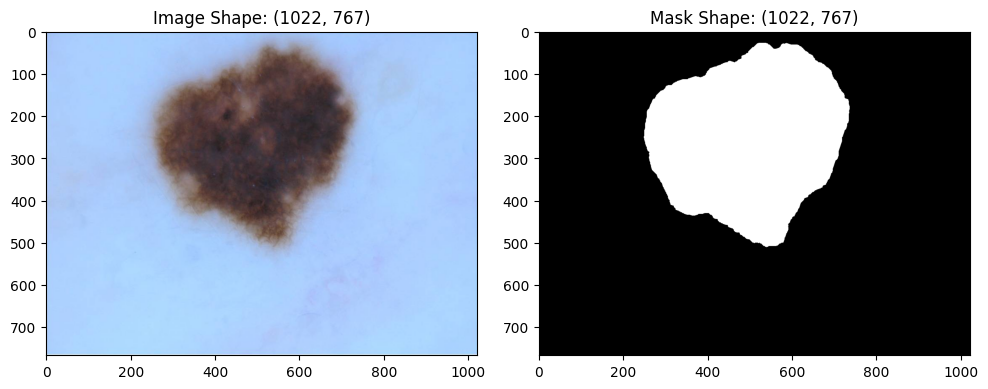

In [7]:
# Visualize the first sample from the training set with its mask
image_path = train_imgs[0]
mask_path = train_msks[0]

image = Image.open(image_path)
mask = Image.open(mask_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Image Shape: {image.size}")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title(f"Mask Shape: {mask.size}")

plt.tight_layout()
plt.show()

Creating datasets and dataloaders

In [8]:
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset

class LesionSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        mask_name = self.mask_paths[idx]

        # Open image and mask, convert them to numpy arrays
        img = Image.open(img_name)
        mask = Image.open(mask_name)

        img = np.array(img)
        mask = np.array(mask)
        mask[mask == 255] = 1  # Normalize mask to binary 0/1

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Ensure tensors
        if not torch.is_tensor(img):
            img = torch.from_numpy(img).float()
        if not torch.is_tensor(mask):
            mask = torch.from_numpy(mask).long()  # long() ensures mask values are integers (needed for CrossEntropyLoss)
        mask = mask.unsqueeze(0)  # Add channel dimension

        return img, mask


In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

size = (256, 256)  # Target image size for training (all images & masks will be resized to this size)

# Augmentations for training set
train_transform = A.Compose([
    # Resize images and masks to a fixed size (important for batching in DataLoader)
    A.Resize(size[0], size[1]),
    
    # Random rotation within ±15 degrees (small angle to mimic real-world variations)
    A.Rotate(limit=15, p=0.1),
    
    # Random horizontal flip (mimics different orientations of lesions)
    A.HorizontalFlip(p=0.5),

    # Normalize image pixel values to [0,1] with mean=0, std=1
    # max_pixel_value=255 ensures 8-bit image scaling
    A.Normalize(mean=(0,0,0), std=(1,1,1), max_pixel_value=255),

    # Convert numpy arrays (H,W,C) → PyTorch tensors (C,H,W)
    ToTensorV2()
])

# Augmentations for validation set (NO random augmentations, only resizing & normalization)
val_transform = A.Compose([
    A.Resize(size[0], size[1]),
    A.Normalize(mean=(0,0,0), std=(1,1,1), max_pixel_value=255),
    ToTensorV2()
])


DATASETS

In [10]:
train_dataset =  LesionSegmentationDataset(train_imgs, train_msks, transform = train_transform)
val_dataset = LesionSegmentationDataset(val_imgs, val_msks, transform = val_transform)
test_dataset = LesionSegmentationDataset(test_images, test_masks, transform = val_transform)

DATALOADERS

In [11]:
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

MODEL DEFINITION

In [12]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # First convolution layer:
        #   - Takes 'in_ch' input channels
        #   - Produces 'out_ch' feature maps
        #   - kernel_size=3 → 3x3 filter (captures local features)
        #   - stride=1, padding=1 → keeps output size same as input
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride=1,padding=1)
        
        self.relu  = nn.ReLU()  # ReLU activation adds non-linearity (so network can learn complex patterns)

        # Second convolution layer:
        #   - Takes 'out_ch' from conv1
        #   - Produces 'out_ch' again
        #   - Same 3x3 kernel
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        # Forward pass:
        # 1. Apply conv1 + ReLU
        # 2. Apply conv2 + ReLU
        # 3. Return output
        # (No pooling here, just feature extraction)
        return self.relu(self.conv2(self.relu(self.conv1(x)))).to(device)


In [13]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()

        # Create a list of "Block"s (Double Conv)
        # Each block goes from chs[i] → chs[i+1]
        # Example: (3→64), (64→128), (128→256), ...
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

        # Max pooling reduces H and W by half after each block
        # This lets the model learn features at different scales
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [14]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs  = chs

        # Up-convolutions (transpose conv) to upsample feature maps
        # Each layer halves the channels and doubles H, W
        self.upconvs  = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])

        # Decoder blocks (double conv) after concatenating skip connections
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x  = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [15]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder  = Decoder(dec_chs)

        # Final 1x1 convolution to produce segmentation mask
        # dec_chs[-1] = number of channels after final decoder block
        # num_class = 1 for binary segmentation (lesion vs background)
        self.head  = nn.Conv2d(dec_chs[-1], num_class, 1)


    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        return out
        

I used `padding=1` for the convolutional layers to maintain the dimension of the output. This is because the mask and the mole image must have the same size.

I also couldn't use larger channel dimensions (e.g., 512 and 1024) because it significantly increases the number of model parameters and, consequently, the memory requirements. However, I added a layer with 32 channels, which helped capture important information from the images, and the model's performance improved compared to the version without this layer.

TRAINING

I tried different combinations of loss functions (Jaccard, Soft BCE, and BCE) and optimizers (SGD, Adam, and RMSprop). In the end, I settled on using Adam as the optimizer and Binary Cross-Entropy as the loss function.

I also implement a decreasing learning rate to avoid oscillatory behavior of the loss function near the minimum. This helped the model converge more effectively and reach a better solution.

In [16]:
model = UNet(enc_chs=(3,32, 64,128,256),   # Encoder channels (input → bottleneck)
             dec_chs=(256, 128, 64, 32),   # Decoder channels (bottleneck → output)
             num_class=1)                  # Binary segmentation (lesion vs background)

# Optimizer: Adam is widely used for segmentation tasks due to adaptive learning rates
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=learning_rate/epochs)
#optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()
#criterion = SoftBCEWithLogitsLoss()
#criterion = JaccardLoss()

scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min', verbose=True)
# factor=0.1 → LR reduced by 10x
# patience=5 → wait 5 epochs before reducing
# mode='min' → monitor validation loss

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
model.to(device)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [18]:
summary(model, input_size=(batch_size,3, size[0],size[1]))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 1, 256, 256]         --
├─Encoder: 1-1                           [16, 32, 256, 256]        --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-1                   [16, 32, 256, 256]        10,144
│    └─MaxPool2d: 2-2                    [16, 32, 128, 128]        --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-2                   [16, 64, 128, 128]        55,424
│    └─MaxPool2d: 2-4                    [16, 64, 64, 64]          --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-3                   [16, 128, 64, 64]         221,440
│    └─MaxPool2d: 2-6                    [16, 128, 32, 32]         --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-4              

In [19]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [20]:
def train_model(model, epochs, train_dataloader, val_dataloader, criterion, optimizer, device, scheduler=None, scheduler_on='train_loss', early_stopper=None):

    train_loss_lst, valid_loss_lst, valid_acc_lst = [], [], []
    model.to(device)

    # --- Dice coefficient function ---
    def dice_coefficient(pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)            # Convert logits to probabilities
        pred = (pred > 0.5).float()           # Threshold to get binary mask
        intersection = (pred * target).sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
        return dice.mean()

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        train_loss = 0
        for images, masks in train_dataloader:
            images, masks = images.to(device), masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_dataloader)
        train_loss_lst.append(avg_train_loss)

        # --- Validation ---
        model.eval()
        val_loss = 0
        val_dice_total = 0
        with torch.no_grad():
            for images, masks in val_dataloader:
                images, masks = images.to(device), masks.to(device).float()
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_dice_total += dice_coefficient(outputs, masks).item()  # <--- works now
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_dice = val_dice_total / len(val_dataloader)
        valid_loss_lst.append(avg_val_loss)
        valid_acc_lst.append(avg_val_dice)

        # --- Early Stopping ---
        if early_stopper:
            early_stopper(avg_val_dice)
            if early_stopper.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # --- Scheduler Step ---
        if scheduler:
            if scheduler_on == 'train_loss':
                scheduler.step(avg_train_loss)
            else:
                scheduler.step(avg_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}')

    return train_loss_lst, valid_loss_lst, valid_acc_lst


In [22]:
# Create EarlyStopping object
early_stopper = EarlyStopping(patience=7, min_delta=0)

# Run the training
train_loss_lst, valid_loss_lst, valid_acc_lst = train_model(
    model=model,
    epochs=50,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,         # optional
    scheduler_on='train_loss',   # optional
    early_stopper=early_stopper  # optional
)

# --- Evaluate Test Loss ---
def evaluate_test_loss(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
    return test_loss / len(test_loader)

test_loss = evaluate_test_loss(model, test_dataloader, criterion, device)
print(f"Final Test Loss: {test_loss:.4f}")

Epoch [1/50] - Train Loss: 0.4253, Val Loss: 0.4040, Val Dice: 0.6186
Epoch [2/50] - Train Loss: 0.4001, Val Loss: 0.3908, Val Dice: 0.6527
Epoch [3/50] - Train Loss: 0.3866, Val Loss: 0.3689, Val Dice: 0.6721
Epoch [4/50] - Train Loss: 0.3528, Val Loss: 0.3205, Val Dice: 0.7502
Epoch [5/50] - Train Loss: 0.3484, Val Loss: 0.3426, Val Dice: 0.7239
Epoch [6/50] - Train Loss: 0.3322, Val Loss: 0.3244, Val Dice: 0.7369
Epoch [7/50] - Train Loss: 0.3383, Val Loss: 0.3307, Val Dice: 0.7514
Epoch [8/50] - Train Loss: 0.3353, Val Loss: 0.3491, Val Dice: 0.7475
Epoch [9/50] - Train Loss: 0.3268, Val Loss: 0.3100, Val Dice: 0.7341
Epoch [10/50] - Train Loss: 0.2978, Val Loss: 0.3141, Val Dice: 0.7479
Epoch [11/50] - Train Loss: 0.2898, Val Loss: 0.2802, Val Dice: 0.7832
Epoch [12/50] - Train Loss: 0.2789, Val Loss: 0.2774, Val Dice: 0.7876
Epoch [13/50] - Train Loss: 0.2728, Val Loss: 0.2584, Val Dice: 0.8112
Epoch [14/50] - Train Loss: 0.2714, Val Loss: 0.3115, Val Dice: 0.7541
Epoch [15/50] -

In [23]:
from sklearn.metrics import precision_score, recall_score

def evaluate_test_metrics(model, test_loader, device):
    model.eval()
    dice_scores, iou_scores, precision_scores, recall_scores = [], [], [], []
    
    def dice_coefficient(pred, target, smooth=1e-6):
        intersection = (pred * target).sum()
        return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    def iou_score(pred, target, smooth=1e-6):
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        return (intersection + smooth) / (union + smooth)
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device).float()
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # flatten for precision/recall
            preds_flat = preds.view(-1).cpu().numpy()
            masks_flat = masks.view(-1).cpu().numpy()

            # metrics
            dice_scores.append(dice_coefficient(preds, masks).item())
            iou_scores.append(iou_score(preds, masks).item())
            precision_scores.append(precision_score(masks_flat, preds_flat, zero_division=0))
            recall_scores.append(recall_score(masks_flat, preds_flat, zero_division=0))

    return {
        "Dice": sum(dice_scores)/len(dice_scores),
        "IoU": sum(iou_scores)/len(iou_scores),
        "Precision": sum(precision_scores)/len(precision_scores),
        "Recall": sum(recall_scores)/len(recall_scores)
    }

metrics = evaluate_test_metrics(model, test_dataloader, device)
print("Test Metrics:", metrics)


Test Metrics: {'Dice': 0.8704497095438256, 'IoU': 0.792065473472439, 'Precision': 0.9070245643864818, 'Recall': 0.8746071545445391}


In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np

def get_confusion_matrix(model, test_loader, device):
    model.eval()
    all_preds, all_masks = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device).float()
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_masks.extend(masks.view(-1).cpu().numpy())

    cm = confusion_matrix(all_masks, all_preds)
    return cm

cm = get_confusion_matrix(model, test_dataloader, device)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[17181225   657954]
 [ 1011974  5986991]]


In [25]:
import time

def measure_inference_speed(model, test_loader, device):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _ = model(images)  # forward pass
    end = time.time()

    total_time = end - start
    num_images = len(test_loader.dataset)
    time_per_image = total_time / num_images
    fps = 1 / time_per_image
    return total_time, time_per_image, fps

total_time, time_per_image, fps = measure_inference_speed(model, test_dataloader, device)
print(f"Inference Time: {total_time:.2f}s for {len(test_dataloader.dataset)} images")
print(f"Time per Image: {time_per_image:.4f}s, FPS: {fps:.2f}")


Inference Time: 17.06s for 379 images
Time per Image: 0.0450s, FPS: 22.21


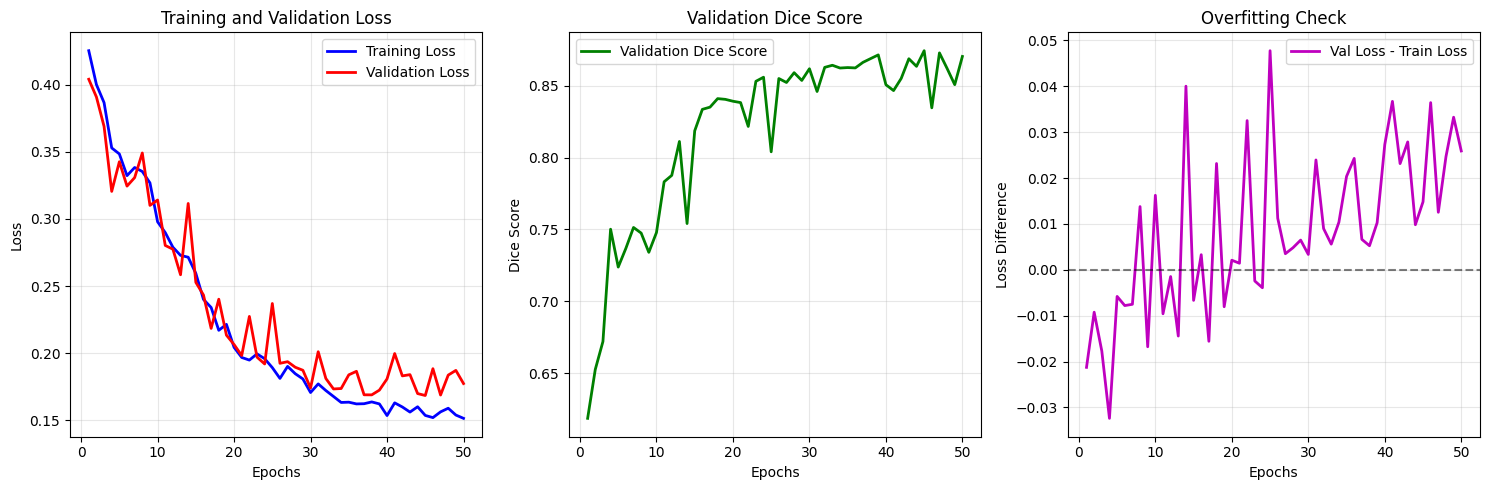

Training Summary:
  Best Validation Dice Score: 0.8743 at epoch 45
  Final Training Loss: 0.1514
  Final Validation Loss: 0.1773
  Final Dice Score: 0.8703
  Model continued improving until the end


In [26]:
def plot_loss_accuracy(train_loss_lst, valid_loss_lst, valid_acc_lst):
    """
    Plot training loss, validation loss, and validation accuracy (Dice score)
    """
    epochs = range(1, len(train_loss_lst) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss_lst, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, valid_loss_lst, 'r-', label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Validation Accuracy (Dice Score)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, valid_acc_lst, 'g-', label='Validation Dice Score', linewidth=2)
    plt.title('Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Loss Difference (Overfitting Check)
    plt.subplot(1, 3, 3)
    loss_diff = [val - train for train, val in zip(train_loss_lst, valid_loss_lst)]
    plt.plot(epochs, loss_diff, 'm-', label='Val Loss - Train Loss', linewidth=2)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.title('Overfitting Check')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Difference')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print training statistics
    print(f"Training Summary:")
    print(f"  Best Validation Dice Score: {max(valid_acc_lst):.4f} at epoch {valid_acc_lst.index(max(valid_acc_lst)) + 1}")
    print(f"  Final Training Loss: {train_loss_lst[-1]:.4f}")
    print(f"  Final Validation Loss: {valid_loss_lst[-1]:.4f}")
    print(f"  Final Dice Score: {valid_acc_lst[-1]:.4f}")
    
    # Check for overfitting
    best_epoch = valid_acc_lst.index(max(valid_acc_lst)) + 1
    if best_epoch < len(valid_acc_lst) * 0.8:
        print(f"  Warning: Best performance was at epoch {best_epoch}, consider early stopping")
    else:
        print(f"  Model continued improving until the end")

# Call the function
plot_loss_accuracy(train_loss_lst, valid_loss_lst, valid_acc_lst)

In [27]:
model.eval()

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

SAVING PART

In [28]:
# Save the model to your Google Drive
torch.save(model.state_dict(), '/kaggle/working/segmentation_model.pth')

In [29]:
import os
import zipfile
from PIL import Image
import torch

# Output folder
output_dir = '/kaggle/working/segmentation_results'
os.makedirs(output_dir, exist_ok=True)

model.eval()  # make sure this is your trained model

with torch.no_grad():
    for i, (images, masks) in enumerate(test_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        preds = preds.cpu().numpy()
        images = images.cpu().permute(0,2,3,1).numpy()
        masks = masks.cpu().numpy()

        for j in range(images.shape[0]):
            idx = i * len(images) + j  # safer than batch_size
            Image.fromarray((images[j]*255).astype('uint8')).save(os.path.join(output_dir, f'image_{idx}.png'))
            Image.fromarray((preds[j][0]*255).astype('uint8')).save(os.path.join(output_dir, f'pred_mask_{idx}.png'))
            Image.fromarray((masks[j][0]*255).astype('uint8')).save(os.path.join(output_dir, f'gt_mask_{idx}.png'))

# Zip everything
zip_path = '/kaggle/working/segmentation_results.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print("Files saved in:", output_dir)
print("ZIP file created at:", zip_path)
print("Saved files:", os.listdir(output_dir))


Files saved in: /kaggle/working/segmentation_results
ZIP file created at: /kaggle/working/segmentation_results.zip
Saved files: ['image_370.png', 'image_79.png', 'image_262.png', 'gt_mask_1.png', 'gt_mask_106.png', 'image_287.png', 'image_310.png', 'image_232.png', 'gt_mask_227.png', 'image_149.png', 'image_128.png', 'pred_mask_288.png', 'image_11.png', 'image_191.png', 'pred_mask_297.png', 'gt_mask_176.png', 'gt_mask_162.png', 'pred_mask_98.png', 'pred_mask_203.png', 'image_237.png', 'image_268.png', 'pred_mask_141.png', 'image_126.png', 'gt_mask_94.png', 'image_192.png', 'image_196.png', 'image_4.png', 'pred_mask_139.png', 'gt_mask_360.png', 'pred_mask_259.png', 'gt_mask_274.png', 'pred_mask_97.png', 'pred_mask_3.png', 'image_130.png', 'pred_mask_251.png', 'image_140.png', 'image_49.png', 'gt_mask_374.png', 'gt_mask_67.png', 'pred_mask_16.png', 'pred_mask_166.png', 'pred_mask_219.png', 'gt_mask_100.png', 'gt_mask_208.png', 'gt_mask_148.png', 'image_84.png', 'gt_mask_239.png', 'pred_m

In [30]:
# Initialize an empty model with the same architecture
upload_model = UNet(enc_chs=(3,32, 64,128,256), dec_chs=(256, 128, 64, 32), num_class=1)

In [31]:
# Load the model from Google Drive
model_path = '/kaggle/working/segmentation_model.pth'
upload_model.load_state_dict(torch.load(model_path,  map_location=torch.device('cpu')))
#upload_model.eval()
#upload_model.to(device)

<All keys matched successfully>

METRICS

The metrics that are used to analyze the performance of the model for this task are fundamental for image segmentation models.

1. **Sensitivity (True Positive Rate, Recall):**
   - Sensitivity measures the ability of a segmentation model to correctly identify positive instances.
   - Formula: Sensitivity = (True Positives) / (True Positives + False Negatives)

2. **Specificity:**
   - Specificity measures the ability of a segmentation model to correctly identify negative instances.
   - Formula: Specificity = (True Negatives) / (True Negatives + False Positives)

3. **Pixel Accuracy:**
   - Pixel accuracy assesses the overall correctness of pixel-wise predictions.
   - Formula: Pixel Accuracy = (Correctly Classified Pixels) / (Total Pixels)

4. **Jaccard Score (Intersection over Union, IoU):**
   - The Jaccard Score calculates the intersection over the union of the predicted and ground truth segmentation masks.
   - Formula: IoU = (Intersection) / (Union)

5. **Dice Score (F1 Score):**
   - The Dice Score measures the similarity between the predicted and ground truth masks.
   - Formula: Dice Score = (2 * True Positives) / (2 * True Positives + False Positives + False Negatives)

In [32]:
import torch
import numpy as np

def check_metrics(dataloader, model, device="cpu"):
    model.eval()
    TP = TN = FP = FN = 0
    dice_scores = []
    jaccard_scores = []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            # Flatten for metric calculation
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            # Dice
            intersection = (preds_flat * masks_flat).sum().item()
            dice = (2. * intersection) / (preds_flat.sum().item() + masks_flat.sum().item() + 1e-8)
            dice_scores.append(dice)
            # Jaccard (IoU)
            union = preds_flat.sum().item() + masks_flat.sum().item() - intersection
            jaccard = intersection / (union + 1e-8)
            jaccard_scores.append(jaccard)
    # Metrics
    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    dice = np.mean(dice_scores)
    jaccard = np.mean(jaccard_scores)
    return sensitivity, specificity, accuracy, jaccard, dice


Why we use each metric:

Sensitivity (Recall): How many actual lesion pixels are correctly identified.

Specificity: How many background pixels are correctly identified.

Accuracy: Overall correctness of predictions.

Dice Coefficient: Overlap between predicted and true masks (common for segmentation).

Jaccard / IoU: Intersection over union of predicted and true masks.

In [33]:
sensitivity, specificity, accuracy, jaccard, dice = check_metrics(test_dataloader, model, device="cuda")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Jaccard (IoU): {jaccard:.4f}")
print(f"Dice: {dice:.4f}")



Sensitivity: 0.8205
Specificity: 0.9716
Accuracy: 0.9290
Jaccard (IoU): 0.7782
Dice: 0.8605


PLOTTING THE RESULT

In [34]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_img_mask_pred(dataset, idx=0, plot_pred=False, model=None, device="cpu"):
    """
    Plots the image, ground truth mask, and (optionally) the predicted mask for a sample from the dataset.
    Args:
        dataset: PyTorch-style dataset returning (image, mask) pairs
        idx: Index of the sample to plot
        plot_pred: If True, plot model prediction
        model: Trained model (required if plot_pred=True)
        device: 'cpu' or 'cuda'
    """
    # Get image and mask
    img, mask = dataset[idx]
    # If tensor, convert to numpy
    if hasattr(img, 'cpu'):
        img_np = img.cpu().numpy()
        if img_np.ndim == 3 and img_np.shape[0] in [1, 3]:
            img_np = np.transpose(img_np, (1, 2, 0))  # C,H,W to H,W,C
    else:
        img_np = img
    if hasattr(mask, 'cpu'):
        mask_np = mask.cpu().numpy()
        if mask_np.ndim == 3:
            mask_np = mask_np[0]
    else:
        mask_np = mask
    # Prepare figure
    n_plots = 3 if plot_pred and model is not None else 2
    plt.figure(figsize=(15, 5))
    plt.subplot(1, n_plots, 1)
    plt.imshow(img_np)
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1, n_plots, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    # Plot prediction if requested
    if plot_pred and model is not None:
        model.eval()
        with torch.no_grad():
            input_tensor = img.unsqueeze(0).to(device)
            pred = model(input_tensor)
            pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
        plt.subplot(1, n_plots, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Explanation in simple words:

The function takes a dataset and an index and retrieves the image and mask at that index.

It converts PyTorch tensors to NumPy arrays so that matplotlib can plot them.

It plots the image and its ground truth mask side by side.

If plot_pred=True and you provide a trained model, it also runs the image through the model and plots the predicted mask.

Thresholding (>0.5) converts the model’s output (probabilities) to binary masks.

The figure layout is adjusted so all plots are neat.

You can now visualize individual samples and see how well your model is segmenting skin lesions.

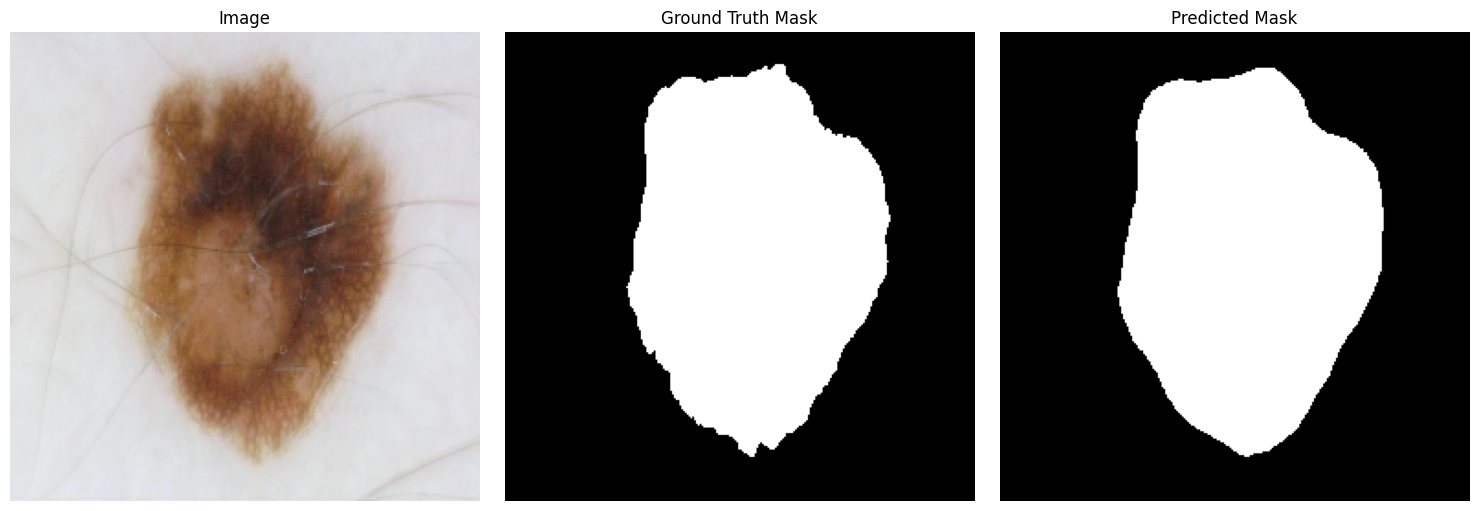

In [35]:
plot_img_mask_pred(test_dataset, idx=0, plot_pred=True, model=model, device="cuda")


RESULTS

The parameters I adjusted during the model training process are as follows:

1. Image size: I settled on a size of 128x128, as it had a minimal negative  impact on performance while significantly reducing memory usage.

2. Number of channels in the convolutional layers of the U-Net.

3. Learning rate, which I chose to decrease based on the loss function's behavior.

4. Batch  size: I opted for a relatively large batch size of 16 to expedite training without consuming excessive memory.

5. Loss function: I found that there was no noticeable difference between Soft BCE and BCE loss, and the model trained poorly with Jaccard.

6. Optimizer: I selected Adam as it was the fastest optimizer for this specific task.

7. Number of epochs: I tried to use as many epochs as possible (50), observing when the loss function almost stopped changing, indicating that the model had learned as much as possible.

8. Data augmentation: I applied standard image transformations for segmentation tasks, using a convenient library that could transform both the mask and the image simultaneously.

The final parameters can be found in the code within this notebook.